In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.morphology import skeletonize


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


# Data loading

In [56]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

# Plotting

In [57]:
def set_axis(axis_data):
    """Helper function to set axis ticks"""
    n = len(axis_data)
    positions = np.linspace(0, n-1, min(10, n))
    labels = [axis_data[int(p)] for p in positions]
    return positions, labels

def plot_data(result, figsize=(12, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot DAS data as a heatmap (time vs distance).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plot
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    df = result['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Plot the data
    im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    
    plt.ylabel('time')
    plt.xlabel('space [m]')
    
    # Add colorbar with custom positioning
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    plt.show()
    
    return fig, ax

def plot_comparison(result1, result2, title1="Original", title2="Processed", 
                    figsize=(24, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot two DAS datasets side by side for comparison.
    
    Parameters:
    -----------
    result1, result2 : dict
        Dictionaries returned by get_range() or filter functions
    title1, title2 : str
        Titles for the left and right plots
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plots
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes objects
    """
    df1 = result1['df'].copy()
    df2 = result2['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df1 -= df1.mean()
        df1 = np.abs(df1)
        df2 -= df2.mean()
        df2 = np.abs(df2)
    
    # Normalize using percentiles
    low, high = np.percentile(df1, percentiles)
    low2, high2 = np.percentile(df2, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    norm2 = Normalize(vmin=low2, vmax=high2, clip=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot left (original)
    im1 = ax1.imshow(df1, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    ax1.set_ylabel('time')
    ax1.set_xlabel('space [m]')
    ax1.set_title(title1)
    
    x_positions1, x_labels1 = set_axis(df1.columns)
    ax1.set_xticks(x_positions1, np.round(x_labels1))
    y_positions1, y_labels1 = set_axis(df1.index.time)
    ax1.set_yticks(y_positions1, y_labels1)
    
    # Plot right (processed)
    im2 = ax2.imshow(df2, interpolation='none', aspect='auto', norm=norm2, cmap=cmap)
    ax2.set_ylabel('time')
    ax2.set_xlabel('space [m]')
    ax2.set_title(title2)
    
    x_positions2, x_labels2 = set_axis(df2.columns)
    ax2.set_xticks(x_positions2, np.round(x_labels2))
    y_positions2, y_labels2 = set_axis(df2.index.time)
    ax2.set_yticks(y_positions2, y_labels2)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Amplitude')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Preprocessing

In [58]:
def merge_similar_values(values, tolerance):
    if not values:
        return []
    
    values = sorted(values)
    merged = [values[0]]
    
    for v in values[1:]:
        if abs(v - merged[-1]) <= tolerance:
            continue
        merged.append(v)
    
    return merged

In [59]:
def bandpass_filter(result, lowcut=5, highcut=50, order=4):
    """
    Apply bandpass filter to DAS data to isolate vehicle frequencies.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lowcut : float
        Low cutoff frequency in Hz (default: 5 Hz)
    highcut : float
        High cutoff frequency in Hz (default: 50 Hz)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    # Normalize cutoff frequencies
    nyquist = fs / 2.0
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to each spatial channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = filtfilt(b, a, data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }
    
def zero_columns(data, col_start, col_end):
    # Zero out specified columns in the DAS data.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = array.copy()
    modified_array[:, col_start:col_end] = 0
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }


# Other functions

In [60]:
def bandstop_filter_frequencies(result, frequencies_to_remove, bandwidth=2.0, order=4, channel_index=None):
    """
    Apply bandstop (band-reject) filters to remove specific frequency bands from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of center frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth around each center frequency to remove in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    channel_index : int or None
        If specified, filter only this channel. If None, filter all channels (default: None)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDSTOP FILTERING")
    if channel_index is not None:
        print(f"Filtering channel: {channel_index}")
    else:
        print(f"Filtering all {data.shape[1]} channels")
    print(f"Removing {len(frequencies_to_remove)} frequency bands:")
    
    # Apply bandstop filter for each frequency
    filtered_data = data.copy()
    
    # Determine which channels to filter
    channels_to_filter = [channel_index] if channel_index is not None else range(filtered_data.shape[1])
    
    for freq in frequencies_to_remove:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        # Design bandstop filter
        # Apply filter to specified channel(s)
        for i in channels_to_filter:
            low = lowcut / nyquist
            high = highcut / nyquist
        for i in range(filtered_data.shape[1]):
        # Design bandstop filter
            b, a = butter(order, [low, high], btype='bandstop')
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
        columns=df.columns
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandpass_keep_frequencies(result, frequencies_to_keep, bandwidth=2.0, order=4, channel_index=None):
    """
    Apply bandpass filters to KEEP ONLY specific frequencies from DAS data.
    All other frequencies will be removed.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_keep : array-like
        List or array of center frequencies [Hz] to KEEP in the signal
    bandwidth : float
        Bandwidth around each center frequency to keep in Hz (default: 2.0)
    order : int
        Filter order (default: 4)
    channel_index : int or None
        If specified, filter only this channel. If None, filter all channels (default: None)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDPASS KEEP ONLY SPECIFIC FREQUENCIES")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    if channel_index is not None:
        print(f"Filtering channel: {channel_index}")
    else:
        print(f"Filtering all {data.shape[1]} channels")
    print(f"Keeping {len(frequencies_to_keep)} frequency bands:")
    
    # Start with zeros for filtered channels, keep original for non-filtered channels
    filtered_data = data.copy() if channel_index is not None else np.zeros_like(data)
    
    # Determine which channels to filter
    channels_to_filter = [channel_index] if channel_index is not None else range(data.shape[1])
    
    # Zero out the channels we're going to filter
    for i in channels_to_filter:
        filtered_data[:, i] = 0
    
    for freq in frequencies_to_keep:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandpass filter
        b, a = butter(order, [low, high], btype='bandpass')
        
        # Apply filter to specified channel(s) and ADD to result
        for i in channels_to_filter:
            filtered_data[:, i] += filtfilt(b, a, data[:, i])
        
        print(f"  Kept {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [61]:
def find_channel_frequencies_fft(result, channel_index=24, threshold_percentile=85, 
                                merge_gap=50, min_sector_length=3, 
                                min_freq=5, max_freq=50, top_n_peaks=1, show_plots=True):
    """
    Find dominant signal frequencies using FFT analysis of high-amplitude sectors.
    
    Instead of calculating f=1/duration, this function applies FFT to each detected
    sector to find the actual oscillation frequencies in the signal content.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    min_freq : float
        Minimum frequency to consider in FFT analysis [Hz] (default: 5)
    max_freq : float
        Maximum frequency to consider in FFT analysis [Hz] (default: 50)
    top_n_peaks : int
        Number of top frequency peaks to extract per sector (default: 1)
    show_plots : bool
        Whether to display visualization plots (default: True)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of dominant frequencies [Hz] found via FFT
        'peak_powers': array of FFT peak powers for each frequency
        'sector_frequencies': list of arrays, each containing top frequencies for one sector
        'sector_avg_frequencies': array of average frequencies for each sector
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    from scipy.fft import rfft, rfftfreq
    
    dt = result['dt']
    data = result['data']
    fs = 1.0 / dt
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate basic properties
    sector_lengths = ends - starts
    durations = sector_lengths * dt
    
    # FFT analysis for each sector
    all_frequencies = []
    all_peak_powers = []
    sector_frequencies_list = []
    sector_avg_frequencies = []
    
    for start, end in zip(starts, ends):
        # Extract sector signal
        sector_signal = channel_data[start:end]
        sector_length = len(sector_signal)
        
        # Apply FFT
        fft_result = rfft(sector_signal)
        fft_freqs = rfftfreq(sector_length, dt)
        fft_power = np.abs(fft_result)
        
        # Filter to frequency range of interest
        freq_mask = (fft_freqs >= min_freq) & (fft_freqs <= max_freq)
        valid_freqs = fft_freqs[freq_mask]
        valid_power = fft_power[freq_mask]
        
        if len(valid_freqs) == 0:
            continue
        
        # Find top N peaks
        n_peaks = min(top_n_peaks, len(valid_power))
        top_indices = np.argpartition(valid_power, -n_peaks)[-n_peaks:]
        top_indices = top_indices[np.argsort(valid_power[top_indices])[::-1]]
        
        sector_freqs = valid_freqs[top_indices]
        sector_powers = valid_power[top_indices]
        
        # Calculate average frequency for this sector
        sector_avg = np.mean(sector_freqs)
        
        # Store results
        sector_frequencies_list.append(sector_freqs)
        sector_avg_frequencies.append(sector_avg)
        all_frequencies.extend(sector_freqs)
        all_peak_powers.extend(sector_powers)
    
    frequencies = np.array(all_frequencies)
    peak_powers = np.array(all_peak_powers)
    sector_avg_frequencies = np.array(sector_avg_frequencies)
    
    print("="*70)
    print(f"CHANNEL {channel_index} FFT FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Sampling frequency (fs): {fs:.2f} Hz")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Frequency range: {min_freq}-{max_freq} Hz")
    print(f"  Top peaks per sector: {top_n_peaks}")
    print(f"  Merged sectors detected: {len(starts)}")
    print(f"  Total frequencies extracted: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED FREQUENCIES (via FFT):")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Power':<12}")
        print(f"{'-'*70}")
        
        displayed = 0
        for i, (start, end, length, duration, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, num_merged)):
            if i < len(sector_frequencies_list):
                for freq, power in zip(sector_frequencies_list[i], 
                                      [peak_powers[j] for j in range(len(peak_powers)) 
                                       if j < len(sector_frequencies_list[i])]):
                    if displayed < 20:
                        print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {power:>10.2e}")
                        displayed += 1
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more frequencies")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(starts)}")
        print(f"  Total frequencies: {len(frequencies)}")
        print(f"  Frequency range: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        print(f"\nSECTOR AVERAGE FREQUENCIES:")
        print(f"  Mean of sector averages: {np.mean(sector_avg_frequencies):.2f} Hz")
        print(f"  Median of sector averages: {np.median(sector_avg_frequencies):.2f} Hz")
        print(f"  Std of sector averages: {np.std(sector_avg_frequencies):.2f} Hz")
        
        # Visualization
        if show_plots:
            fig, axes = plt.subplots(2, 2, figsize=(20, 10))
            
            # Plot 1: Channel signal with threshold
            ax = axes[0, 0]
            time_axis = np.arange(len(channel_data)) * dt
            ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
            ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
            ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Plot 2: Binary signal with sectors highlighted
            ax = axes[0, 1]
            ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
            for start, end in zip(starts[:50], ends[:50]):
                ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Binary (0/1)')
            ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Plot 3: Frequency histogram
            ax = axes[1, 0]
            ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
            ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
            ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                       linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
            ax.set_xlabel('Frequency [Hz]')
            ax.set_ylabel('Count')
            ax.set_title('FFT Frequency Distribution', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Plot 4: Frequency vs Power scatter
            ax = axes[1, 1]
            ax.scatter(frequencies, peak_powers, alpha=0.5, s=20)
            ax.set_xlabel('Frequency [Hz]')
            ax.set_ylabel('FFT Power')
            ax.set_title('Frequency vs FFT Power', fontsize=14, fontweight='bold')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print("\nNo frequencies detected in specified range.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'peak_powers': peak_powers,
        'sector_frequencies': sector_frequencies_list,
        'sector_avg_frequencies': sector_avg_frequencies,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

In [62]:
def detect_continuous_regions_channel(result, channel_index, threshold_percentile=70):
    """
    Detect continuous regions across a given channel where values exceed a threshold.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (0-based)
    threshold_percentile : float
        Percentile threshold for detection (0-100, default: 70)
    
    Returns:
    --------
    list of dict : List of detected regions with properties:
        [{'start': int, 'end': int, 'midpoint': int, 'length': int}, ...]
    """
    from scipy.ndimage import label
    
    data = result['data']
    channel_data = data[:, channel_index]
    
    # Calculate threshold and create binary mask
    threshold = np.percentile(channel_data, threshold_percentile)
    binary_mask = channel_data > threshold
    
    # Label connected components
    labeled_array, num_features = label(binary_mask)
    
    # Extract region properties
    regions = []
    for region_label in range(1, num_features + 1):
        region_indices = np.where(labeled_array == region_label)[0]
        
        if len(region_indices) > 0:
            start = region_indices[0]
            end = region_indices[-1]
            length = len(region_indices)
            midpoint = (start + end) // 2
            
            regions.append({
                'start': start,
                'end': end,
                'midpoint': midpoint,
                'length': length
            })
    
    return regions

In [63]:
def horizontal_sobel_filter(result, intensity=1.0, channel_independent=False):
    """
    Apply horizontal Sobel filter to detect edges along the time axis.
    This enhances horizontal features like vehicle signatures moving across channels.
    
    The Sobel operator calculates the gradient in the horizontal direction,
    highlighting transitions and edges in the time domain.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    intensity : float
        Edge intensity multiplier (default: 1.0)
        Values > 1.0 increase contrast and edge visibility
        Values < 1.0 reduce edge intensity
        Recommended range: 0.5 to 5.0
    channel_independent : bool
        If True, process each channel independently (no cross-channel influence)
        If False, use standard 2D Sobel filter (default: False)
    
    Returns:
    --------
    dict : Same structure as input with Sobel-filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import sobel
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL SOBEL FILTER")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Edge intensity multiplier: {intensity}")
    print(f"Channel independent: {channel_independent}")
    print(f"Applying horizontal gradient detection...")
    
    if channel_independent:
        # Process each channel independently using 1D gradient
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            # Use simple gradient along time axis for each channel
            channel_gradient = np.gradient(data[:, i])
            filtered_data[:, i] = channel_gradient
        print(f"  Mode: 1D gradient per channel (no cross-channel mixing)")
    else:
        # Apply standard 2D horizontal Sobel filter
        # axis=1 means horizontal direction (along time axis)
        filtered_data = sobel(data, axis=1)
        print(f"  Mode: 2D Sobel (includes cross-channel smoothing)")
    
    # Apply intensity multiplier
    filtered_data = filtered_data * intensity
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    filtered_mean = np.mean(np.abs(filtered_data))
    original_max = np.max(np.abs(data))
    filtered_max = np.max(np.abs(filtered_data))
    
    print(f"\nOriginal data:")
    print(f"  Mean absolute value: {original_mean:.6f}")
    print(f"  Max absolute value: {original_max:.6f}")
    print(f"\nFiltered data (horizontal edges):")
    print(f"  Mean absolute value: {filtered_mean:.6f}")
    print(f"  Max absolute value: {filtered_max:.6f}")
    print(f"  Amplitude ratio: {filtered_max / original_max:.2f}")
    print(f"  Edge enhancement: {intensity}x")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [64]:
def line_detection_bfs(result, starting_points, starting_channel, threshold_percentile=50, 
                       display_data=None, min_component_size=10, max_branch_angle=45):
    """
    Detect lines using BFS from starting points, following vehicle trajectories.
    For each starting point, expands along the expected trajectory and fits a line.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    starting_points : list of int
        List of time indices where trajectories start on the starting_channel
    starting_channel : int
        Channel index where starting_points are located
    threshold_percentile : float
        Percentile threshold for binary mask (default: 50)
    display_data : dict or None
        Data to display lines on (e.g., original unprocessed data for visualization)
        If None, uses result data (default: None)
    min_component_size : int
        Minimum number of pixels in a component to fit a line (default: 10)
    max_branch_angle : float
        Maximum angle deviation (degrees) for branching detection (default: 45)
        Smaller values = stricter trajectory following
    
    Returns:
    --------
    dict : Dictionary containing:
        {
            'lines': list of line dicts with:
                - 'slope': line slope (channels per time sample)
                - 'intercept': line intercept
                - 'velocity': velocity in m/s
                - 'angle': angle in degrees
                - 'component_mask': binary mask of the component
                - 'points': list of (time_idx, channel_idx) coordinates
                - 'start_point': starting (time_idx, channel_idx)
                - 'r_squared': goodness of fit
            'all_components_mask': combined binary mask of all components
            'data': original data
            'dt': temporal resolution
            'dx': spatial resolution
        }
    """
    from collections import deque
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    
    # Use display_data if provided, otherwise use result data
    if display_data is not None:
        display_image = display_data['data'].copy()
    else:
        display_image = data.copy()
    
    # Calculate threshold and create binary mask
    threshold = np.percentile(np.abs(data), threshold_percentile)
    binary_mask = np.abs(data) > threshold
    
    n_time, n_channels = data.shape
    
    print("="*70)
    print("LINE DETECTION - BFS WITH TRAJECTORY FOLLOWING")
    print("="*70)
    print(f"Data shape: {data.shape} (time x channels)")
    print(f"Starting channel: {starting_channel}")
    print(f"Starting points: {len(starting_points)}")
    print(f"Threshold percentile: {threshold_percentile}% (value: {threshold:.6f})")
    print(f"Min component size: {min_component_size} pixels")
    print(f"Max branch angle: {max_branch_angle}°")
    
    lines = []
    all_components_mask = np.zeros_like(binary_mask, dtype=bool)
    
    # First pass: collect all pixels for each trajectory, allowing overlaps
    print("\n=== FIRST PASS: Collecting trajectories (overlaps allowed) ===")
    
    trajectory_assignments = {}  # (time, channel) -> list of trajectory indices
    preliminary_trajectories = []
    
    for sp_idx, start_time in enumerate(starting_points):
        print(f"\n--- Processing starting point {sp_idx + 1}/{len(starting_points)} at time={start_time} ---")
        
        start_point = (start_time, starting_channel)
        
        # Check if starting point is valid
        if not (0 <= start_time < n_time and 0 <= starting_channel < n_channels):
            print(f"  SKIP: Starting point out of bounds")
            continue
            
        if not binary_mask[start_time, starting_channel]:
            print(f"  SKIP: Starting point below threshold")
            continue
        
        # BFS with special rules:
        # - In current channel: fill ALL continuous pixels vertically (any time)
        # - To move channels: only go forward (increasing channel index)
        visited_this_trajectory = set()
        queue = deque([start_point])
        visited_this_trajectory.add(start_point)
        component_points = [start_point]
        
        # Track assignment
        if start_point not in trajectory_assignments:
            trajectory_assignments[start_point] = []
        trajectory_assignments[start_point].append(sp_idx)
        
        # Process channel by channel, moving forward only
        channels_to_process = deque([starting_channel])
        processed_channels = set()
        
        while channels_to_process:
            current_channel = channels_to_process.popleft()
            
            # Skip if already processed
            if current_channel in processed_channels:
                continue
            
            processed_channels.add(current_channel)
            
            # Fill entire column at current channel (all vertically connected pixels)
            # Find seed points in this channel
            seed_points = [(t, current_channel) for t, c in component_points if c == current_channel]
            
            if not seed_points:
                continue
            
            # BFS to fill column
            column_visited = set()
            column_queue = deque(seed_points)
            for p in seed_points:
                column_visited.add(p)
            
            while column_queue:
                curr_t, curr_c = column_queue.popleft()
                
                # Check adjacent time steps (same channel)
                for t in [-1, 1]:  # Up and down in time
                    next_t = curr_t + t
                    next_point = (next_t, curr_c)
                    
                    # Bounds check
                    if not (0 <= next_t < n_time):
                        continue
                    
                    # Check if pixel exists
                    if not binary_mask[next_point]:
                        continue
                    
                    # Skip if already visited in column filling
                    if next_point in column_visited:
                        continue
                    
                    column_visited.add(next_point)
                    column_queue.append(next_point)
                    
                    # Add to trajectory
                    if next_point not in visited_this_trajectory:
                        visited_this_trajectory.add(next_point)
                        component_points.append(next_point)
                        
                        # Track assignment
                        if next_point not in trajectory_assignments:
                            trajectory_assignments[next_point] = []
                        trajectory_assignments[next_point].append(sp_idx)
            
            # Now look for next channels (only forward)
            column_pixels = [p for p in component_points if p[1] == current_channel]
            
            # Try to jump to next channels
            for pixel_time, pixel_channel in column_pixels:
                # Only move forward in channels (increasing direction)
                for dc in [1, 2]:  # Try next 2 channels
                    next_channel = pixel_channel + dc
                    
                    # Bounds check
                    if not (0 <= next_channel < n_channels):
                        continue
                    
                    # Skip if already processed
                    if next_channel in processed_channels:
                        continue
                    
                    # Look for pixels in the next channel at nearby time steps
                    found_connection = False
                    for t in [-2, -1, 0, 1, 2]:  # Look at nearby time steps
                        next_time = pixel_time + t
                        next_point = (next_time, next_channel)
                        
                        # Bounds check
                        if not (0 <= next_time < n_time):
                            continue
                        
                        # Check if pixel exists
                        if not binary_mask[next_point]:
                            continue
                        
                        # Skip if already visited
                        if next_point in visited_this_trajectory:
                            continue
                        
                        # Add this pixel and queue the channel for processing
                        visited_this_trajectory.add(next_point)
                        component_points.append(next_point)
                        
                        # Track assignment
                        if next_point not in trajectory_assignments:
                            trajectory_assignments[next_point] = []
                        trajectory_assignments[next_point].append(sp_idx)
                        
                        # Queue this channel for column filling
                        if next_channel not in processed_channels:
                            channels_to_process.append(next_channel)
                        
                        found_connection = True
                        break  # Only take first match per (pixel, dc) combination
                    
                    # If we found connection, don't look at dc+2
                    if found_connection:
                        break
        
        if len(component_points) < min_component_size:
            print(f"  SKIP: Component too small ({len(component_points)} pixels)")
            continue
        
        print(f"  Component size: {len(component_points)} pixels")
        preliminary_trajectories.append({
            'trajectory_id': sp_idx,
            'points': component_points,
            'start_point': start_point
        })
    
    # Identify pixels assigned to multiple trajectories (crossing points)
    crossing_pixels = {point for point, assignments in trajectory_assignments.items() 
                      if len(assignments) > 1}
    
    print(f"\n=== CROSSING ANALYSIS ===")
    print(f"Total crossing pixels: {len(crossing_pixels)}")
    
    # Second pass: trim trajectories at crossing points
    print("\n=== SECOND PASS: Trimming at crossings ===")
    
    for traj in preliminary_trajectories:
        traj_id = traj['trajectory_id']
        points = traj['points']
        start_point = traj['start_point']
        
        print(f"\n--- Trajectory {traj_id + 1} (started at t={start_point[0]}) ---")
        print(f"  Original points: {len(points)}")
        
        # Sort points by channel (since we move forward in channels)
        points_sorted = sorted(points, key=lambda p: (p[1], p[0]))  # Sort by channel, then time
        
        # Keep points until we hit a crossing with ANOTHER trajectory
        final_points = []
        crossing_encountered = False
        
        for point in points_sorted:
            if point in crossing_pixels:
                # Check if this crossing is with another trajectory
                other_trajectories = [t for t in trajectory_assignments[point] if t != traj_id]
                if other_trajectories:
                    print(f"  Crossing detected at time={point[0]}, channel={point[1]}")
                    print(f"  Stopping before crossing (keeping {len(final_points)} points)")
                    crossing_encountered = True
                    break
            final_points.append(point)
        
        # If we didn't encounter crossing, keep all points
        if not final_points and points:
            # Edge case: starting point is a crossing - take some points anyway
            final_points = points_sorted[:min(20, len(points_sorted))]
            print(f"  Starting point is crossing, taking first {len(final_points)} points")
        
        if len(final_points) < min_component_size:
            print(f"  SKIP: Too small after trimming ({len(final_points)} pixels)")
            continue
        
        print(f"  Final points: {len(final_points)} pixels")
        
        # Debug: check time and channel range
        times_in_component = [p[0] for p in final_points]
        channels_in_component = [p[1] for p in final_points]
        time_range = max(times_in_component) - min(times_in_component)
        channel_range = max(channels_in_component) - min(channels_in_component)
        time_range_seconds = time_range * dt
        channel_range_meters = channel_range * dx
        print(f"  Time range: {min(times_in_component)*dt:.3f}s to {max(times_in_component)*dt:.3f}s (span: {time_range_seconds:.3f}s)")
        print(f"  Channel range: {min(channels_in_component)*dx:.1f}m to {max(channels_in_component)*dx:.1f}m (span: {channel_range_meters:.1f}m)")
        
        # Create component mask
        component_mask = np.zeros_like(binary_mask, dtype=bool)
        for t, c in final_points:
            component_mask[t, c] = True
        
        # Create line between starting point and middle point of last channel
        # Find the last (highest) channel
        last_channel = max(channels_in_component)
        
        # Find all points in the last channel
        last_channel_points = [(t, c) for t, c in final_points if c == last_channel]
        
        # Find middle point (median time) in last channel
        last_channel_times = [t for t, c in last_channel_points]
        middle_time_last_channel = int(np.median(last_channel_times))
        end_point = (middle_time_last_channel, last_channel)
        
        # Calculate line from start_point to end_point
        start_t, start_c = start_point
        end_t, end_c = end_point
        
        # Calculate slope and intercept
        if end_t != start_t:
            slope = (end_c - start_c) / (end_t - start_t)
            intercept = start_c - slope * start_t
        else:
            # Vertical line (same time) - shouldn't happen but handle it
            slope = 0
            intercept = start_c
        
        # Calculate R-squared using all points to measure fit quality
        time_coords = np.array([p[0] for p in final_points]).reshape(-1, 1)
        channel_coords = np.array([p[1] for p in final_points])
        channel_pred = slope * time_coords.flatten() + intercept
        r_squared = r2_score(channel_coords, channel_pred)
        
        # Calculate velocity: velocity = (delta_space) / (delta_time)
        # slope is in channels/sample, convert to m/s
        velocity_m_per_s = (slope * dx) / dt
        
        if abs(velocity_m_per_s) == 0 or abs(velocity_m_per_s) > 50:
            print(f"  SKIP: Invalid velocity ({velocity_m_per_s:.2f} m/s)")
            continue
        
        # Calculate angle
        angle_rad = np.arctan(slope)
        angle_deg = np.degrees(angle_rad)
        
        print(f"  Line fitted (start to end):")
        print(f"    Start point: time={start_t*dt:.3f}s (sample {start_t}), channel={start_c*dx:.1f}m (ch {start_c})")
        print(f"    End point: time={end_t*dt:.3f}s (sample {end_t}), channel={end_c*dx:.1f}m (ch {end_c}) (median of last channel)")
        print(f"    Slope: {slope:.4f} channels/sample")
        print(f"    Intercept: {intercept:.2f} channels")
        print(f"    Velocity: {velocity_m_per_s:.2f} m/s")
        print(f"    Angle: {angle_deg:.2f}°")
        print(f"    R² (fit to all points): {r_squared:.4f}")
        
        lines.append({
            'slope': slope,
            'intercept': intercept,
            'velocity': velocity_m_per_s,
            'angle': angle_deg,
            'component_mask': component_mask,
            'points': final_points,
            'start_point': start_point,
            'end_point': end_point,
            'start_xy': (start_c, start_t),  # (x, y) in pixel coordinates: (channel, time)
            'end_xy': (end_c, end_t),  # (x, y) in pixel coordinates: (channel, time)
            'r_squared': r_squared,
            'n_points': len(final_points)
        })
        
        # Add to combined mask
        all_components_mask |= component_mask
    
    print(f"\n{'='*70}")
    print(f"SUMMARY: Detected {len(lines)} lines from {len(starting_points)} starting points")
    if lines:
        avg_velocity = np.mean([l['velocity'] for l in lines])
        avg_r2 = np.mean([l['r_squared'] for l in lines])
        print(f"Average velocity: {avg_velocity:.2f} m/s")
        print(f"Average R²: {avg_r2:.4f}")
    print("="*70 + "\n")
    
    # Visualization
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from matplotlib.gridspec import GridSpec
    
    # Use GridSpec to control subplot sizes - make statistics panel scrollable by limiting its width
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.6], hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax_stats = fig.add_subplot(gs[:, 2])  # Spans both rows, narrower column
    
    # Prepare display image with transformation (like plot_data)
    display_for_plot = display_image.copy()
    display_for_plot -= display_for_plot.mean()
    display_for_plot = np.abs(display_for_plot)
    
    # Normalize using percentiles (like plot_data)
    low, high = np.percentile(display_for_plot, [3, 99])
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    # Plot 1: Original/Display data with detected lines
    im0 = ax1.imshow(display_for_plot, aspect='auto', cmap='viridis',
                            norm=norm, interpolation='none')
    ax1.set_title('Detected Lines on Data', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Channel')
    ax1.set_ylabel('Time Sample')
    cbar0 = plt.colorbar(im0, ax=ax1, label='Amplitude')
    
    # Draw fitted lines with high visibility
    colors = plt.cm.rainbow(np.linspace(0, 1, len(lines)))
    for i, (line, color) in enumerate(zip(lines, colors)):
        # Draw line across entire time range in pixel coordinates
        t_line = np.array([0, n_time - 1])
        c_line = line['slope'] * t_line + line['intercept']
        
        # Plot in pixel coordinates: x=channel, y=time
        ax1.plot(c_line, t_line, color='black', linewidth=4, alpha=0.8, zorder=10)
        ax1.plot(c_line, t_line, color=color, linewidth=2.5, 
                       label=f'Line {i+1}: {line["velocity"]:.1f} m/s', alpha=0.9, zorder=11)
        
        # Mark starting point
        start_t, start_c = line['start_point']
        ax1.plot(start_c, start_t, 'o', color='black', 
                       markersize=12, zorder=12)
        ax1.plot(start_c, start_t, 'o', color=color, 
                       markersize=8, markeredgecolor='white', markeredgewidth=2, zorder=13)
    
    ax1.legend(loc='best', fontsize=8)
    ax1.set_xlim(0, n_channels - 1)
    ax1.grid(True, alpha=0.3)
    
    y_positions = np.linspace(0, n_time - 1, 8)
    y_labels = [f'{int(pos * dt)}' for pos in y_positions]
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(y_labels)
    ax1.set_ylabel('Time (s)')
    
    # Plot 2: Binary mask with components
    im1 = ax2.imshow(binary_mask, aspect='auto', cmap='gray')
    ax2.set_title('Binary Mask with Detected Components', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Channel')
    y_positions = np.linspace(0, n_time - 1, 8)
    y_labels = [f'{int(pos * dt)}' for pos in y_positions]
    ax2.set_yticks(y_positions)
    ax2.set_yticklabels(y_labels)
    ax2.set_ylabel('Time (s)')
    
    # Overlay components in color
    for i, (line, color) in enumerate(zip(lines, colors)):
        component_colored = line['component_mask'].astype(float)
        component_colored[component_colored == 0] = np.nan
        ax2.imshow(component_colored, aspect='auto', cmap=plt.cm.colors.ListedColormap([color]),
                         alpha=0.6)
        
        # Mark starting point
        start_t, start_c = line['start_point']
        ax2.plot(start_c, start_t, 'o', color=color, 
                       markersize=8, markeredgecolor='white', markeredgewidth=1.5)
    
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Individual components separated
    ax3.imshow(display_image, aspect='auto', cmap='gray', alpha=0.3)
    ax3.set_title('Separated Components with Lines', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Channel')
    y_positions = np.linspace(0, n_time - 1, 8)
    y_labels = [f'{int(pos * dt)}' for pos in y_positions]
    ax3.set_yticks(y_positions)
    ax3.set_yticklabels(y_labels)
    ax3.set_ylabel('Time (s)')
    
    for i, (line, color) in enumerate(zip(lines, colors)):
        # Plot component points in pixel coordinates
        points = np.array(line['points'])
        t_points = points[:, 0]  # Time indices
        c_points = points[:, 1]  # Channel indices
        # x=channel, y=time
        ax3.scatter(c_points, t_points, c=[color], s=5, alpha=0.6, label=f'Comp {i+1}')
        
        # Draw fitted line
        t_min, t_max = points[:, 0].min(), points[:, 0].max()
        t_line = np.array([t_min, t_max])
        c_line = line['slope'] * t_line + line['intercept']
        # x=channel, y=time
        ax3.plot(c_line, t_line, color=color, linewidth=2, linestyle='--')
    
    ax3.legend(loc='best', fontsize=8, markerscale=2)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 257)  # Limit horizontal axis to 0-250m
    
    # Plot 4: Empty placeholder (removed to save space)
    ax4.axis('off')
    
    # Statistics panel (right side, spans full height)
    ax_stats.axis('off')
    
    if lines:
        stats_text = "LINE DETECTION STATISTICS\n" + "="*40 + "\n\n"
        stats_text += f"Total lines detected: {len(lines)}\n"
        stats_text += f"Starting points processed: {len(starting_points)}\n\n"
        
        for i, line in enumerate(lines):
            stats_text += f"Line {i+1}:\n"
            stats_text += f"  Start: t={line['start_point'][0]*dt:.3f}s, ch={line['start_point'][1]*dx:.1f}m\n"
            stats_text += f"  Points: {line['n_points']}\n"
            stats_text += f"  Velocity: {line['velocity']:.2f} m/s\n"
            stats_text += f"  Angle: {line['angle']:.2f}°\n"
            stats_text += f"  Slope: {line['slope']:.4f}\n"
            stats_text += f"  R²: {line['r_squared']:.4f}\n\n"
        
        ax_stats.text(0.05, 0.98, stats_text, transform=ax_stats.transAxes,
                       fontsize=9, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        ax_stats.text(0.5, 0.5, 'No lines detected', transform=ax_stats.transAxes,
                       fontsize=14, ha='center', va='center')
    
    plt.show()
    
    return {
        'lines': lines,
        'all_components_mask': all_components_mask,
        'binary_mask': binary_mask,
        'data': data,
        'display_data': display_image,
        'dt': dt,
        'dx': dx
    }

In [65]:
def binary_threshold_filter(result, threshold_percentile=50, mode='absolute', keep_values=False):
    """
    Apply binary thresholding to DAS data to create a binary mask or zero out low-amplitude values.
    
    This creates a binary representation where values above threshold become 1 (or original value)
    and values below threshold become 0.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    threshold_percentile : float
        Percentile threshold for binarization (default: 50)
        Higher values = more selective (only strongest signals pass)
    mode : str
        Thresholding mode (default: 'absolute')
        'absolute': Threshold based on absolute values |data|
        'positive': Threshold only positive values
        'negative': Threshold only negative values
    keep_values : bool
        If True, keeps original values above threshold (default: False)
        If False, creates binary output (0 or 1)
    
    Returns:
    --------
    dict : Same structure as input with thresholded data
        {'data': thresholded_array, 'df': thresholded_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("BINARY THRESHOLD FILTER")
    print("="*70)
    print(f"Threshold percentile: {threshold_percentile}%")
    print(f"Mode: {mode}")
    print(f"Keep original values: {keep_values}")
    
    # Calculate threshold based on mode
    if mode == 'absolute':
        threshold_value = np.percentile(np.abs(data), threshold_percentile)
        mask = np.abs(data) > threshold_value
        print(f"Threshold value (absolute): {threshold_value:.6f}")
        
    elif mode == 'positive':
        positive_data = data[data > 0]
        if len(positive_data) > 0:
            threshold_value = np.percentile(positive_data, threshold_percentile)
            mask = data > threshold_value
        else:
            threshold_value = 0
            mask = np.zeros_like(data, dtype=bool)
        print(f"Threshold value (positive): {threshold_value:.6f}")
        
    elif mode == 'negative':
        negative_data = data[data < 0]
        if len(negative_data) > 0:
            threshold_value = np.percentile(np.abs(negative_data), threshold_percentile)
            mask = data < -threshold_value
        else:
            threshold_value = 0
            mask = np.zeros_like(data, dtype=bool)
        print(f"Threshold value (negative): {threshold_value:.6f}")
        
    else:
        raise ValueError(f"Unknown mode: {mode}. Use 'absolute', 'positive', or 'negative'.")
    
    # Apply threshold
    if keep_values:
        # Keep original values where mask is True, zero elsewhere
        filtered_data = np.where(mask, data, 0)
        print(f"Output: Original values above threshold, zeros below")
    else:
        # Create binary mask (0 or 1)
        filtered_data = mask.astype(float)
        print(f"Output: Binary (0 or 1)")
    
    # Calculate statistics
    total_samples = data.size
    samples_above = np.sum(mask)
    samples_below = total_samples - samples_above
    percent_above = (samples_above / total_samples) * 100
    
    print(f"\nThresholding statistics:")
    print(f"  Total samples: {total_samples}")
    print(f"  Samples above threshold: {samples_above} ({percent_above:.2f}%)")
    print(f"  Samples below threshold: {samples_below} ({100 - percent_above:.2f}%)")
    
    if keep_values:
        print(f"  Mean of kept values: {np.mean(filtered_data[filtered_data != 0]):.6f}")
        print(f"  Max of kept values: {np.max(np.abs(filtered_data)):.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [66]:
def aspect_ratio_correction(result, scale_time=1.0/23.0, scale_space=5.0):
    """
    Correct aspect ratio of DAS data by rescaling time and space dimensions.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    scale_time : float
        Scale factor for time axis (default: 1/23 to downsample ~75000 -> ~3250)
    scale_space : float
        Scale factor for space axis (default: 5 to upsample ~52 -> ~260)
    
    Returns:
    --------
    dict : Same structure as input with rescaled data and CORRECTED dt/dx
        {'data': rescaled_array, 'df': rescaled_dataframe, 'dt': new_dt, 'dx': new_dx}
    """
    from skimage.transform import rescale
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("ASPECT RATIO CORRECTION")
    print("="*70)
    print(f"Original shape: {data.shape} (time x space)")
    print(f"Original dt: {dt:.6f} s, dx: {dx:.4f} m")
    print(f"Scale time by: {scale_time:.4f}")
    print(f"Scale space by: {scale_space:.1f}")
    print(f"Target shape: ~({int(data.shape[0]*scale_time)} x {int(data.shape[1]*scale_space)})")
    
    # Rescale data - FAST, no anti-aliasing
    rescaled_data = rescale(data, (scale_time, scale_space), 
                           order=1,  # Linear interpolation (faster)
                           mode='edge', 
                           anti_aliasing=False,  # Skip anti-aliasing (much faster)
                           preserve_range=True)
    
    print(f"Actual rescaled shape: {rescaled_data.shape}")
    
    # CORRECT dt and dx based on scaling
    # If we downsample time by 1/23, each sample represents 23x more time
    new_dt = dt / scale_time
    # If we upsample space by 5x, each sample represents 1/5 the distance
    new_dx = dx / scale_space
    
    print(f"\nNew sampling:")
    print(f"  dt: {new_dt:.6f} s (was {dt:.6f} s, factor: {new_dt/dt:.2f}x)")
    print(f"  dx: {new_dx:.4f} m (was {dx:.4f} m, factor: {new_dx/dx:.2f}x)")
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    rescaled_mean = np.mean(np.abs(rescaled_data))
    original_max = np.max(np.abs(data))
    rescaled_max = np.max(np.abs(rescaled_data))
    
    print(f"\nData statistics:")
    print(f"  Original - Mean: {original_mean:.6e}, Max: {original_max:.6e}")
    print(f"  Rescaled - Mean: {rescaled_mean:.6e}, Max: {rescaled_max:.6e}")
    print("="*70 + "\n")
    
    # Create rescaled DataFrame with proper datetime index
    start_time = df.index[0] if hasattr(df.index, '__getitem__') else pd.Timestamp('2024-05-07 00:00:00')
    new_index = pd.date_range(start=start_time, periods=rescaled_data.shape[0], freq=f"{new_dt}s")
    
    rescaled_df = pd.DataFrame(
        data=rescaled_data,
        index=new_index,
        columns=np.arange(rescaled_data.shape[1]) * new_dx
    )
    
    return {
        'data': rescaled_data,
        'df': rescaled_df,
        'dt': new_dt,  # CORRECTED: adjusted for time scaling
        'dx': new_dx,  # CORRECTED: adjusted for space scaling
        'scale_time': scale_time,
        'scale_space': scale_space
    }

In [67]:
def noise_removal_only(result, threshold_strong_percentile=99, threshold_weak_percentile=99, median_size=15):
    """
    Remove noise from data - fragment z smart_preprocessing który usuwa szum.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    threshold_strong_percentile : float
        Percentile for strong signals to keep unchanged (default: 99)
    threshold_weak_percentile : float
        Percentile for weak signals to remove (default: 99)
    median_size : int
        Size of median filter for medium-strength signals (default: 15)
    
    Returns:
    --------
    dict : Same structure as input with noise-removed data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import median_filter
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    n_time, n_space = data.shape
    
    print("="*70)
    print("NOISE REMOVAL")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Strong signal threshold: {threshold_strong_percentile}th percentile")
    print(f"Weak signal threshold: {threshold_weak_percentile}th percentile")
    print(f"Median filter size: {median_size}")
    
    # Process all columns
    data_filtered = data.copy()
    
    for ch in range(n_space):
        channel = data[:, ch]
        abs_channel = np.abs(channel)
        
        # Thresholds: STRONG (keep) and WEAK (remove)
        threshold_strong = np.percentile(abs_channel, threshold_strong_percentile)
        threshold_weak = np.percentile(abs_channel, threshold_weak_percentile)
        
        # Masks
        strong_mask = abs_channel > threshold_strong  # Very strong - KEEP
        weak_mask = abs_channel < threshold_weak      # Weak - REMOVE
        
        # Remove weak points
        result_channel = channel.copy()
        result_channel[weak_mask] = 0  # Remove weak points completely
        
        # For medium signals (between weak and strong) - median filter
        medium_mask = ~strong_mask & ~weak_mask
        if np.any(medium_mask):
            filtered = median_filter(channel, size=median_size)
            result_channel[medium_mask] = filtered[medium_mask]
        
        data_filtered[:, ch] = result_channel
    
    # Statistics
    original_nonzero = np.count_nonzero(data)
    filtered_nonzero = np.count_nonzero(data_filtered)
    removed_percent = (1 - filtered_nonzero / original_nonzero) * 100
    
    print(f"\nProcessed {n_space} columns")
    print(f"Original non-zero samples: {original_nonzero}")
    print(f"Filtered non-zero samples: {filtered_nonzero}")
    print(f"Removed: {removed_percent:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=data_filtered,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': data_filtered,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [68]:
def morphological_closing(result, structure_size=5, iterations=1, threshold_percentile=None):
    """
    Apply morphological closing operation to fill gaps and connect nearby regions.
    
    Closing = Dilation followed by Erosion
    Useful for: connecting broken lines, filling small holes, bridging gaps
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    structure_size : int or tuple
        Size of structuring element (default: 5)
        If int: creates square structuring element
        If tuple (height, width): creates rectangular element
    iterations : int
        Number of times to apply the operation (default: 1)
    threshold_percentile : float, optional
        If provided, binarize data first using this percentile threshold
        If None, operates on data as-is
    
    Returns:
    --------
    dict : Same structure as input with closing applied
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_closing, grey_closing
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("MORPHOLOGICAL CLOSING")
    print("="*70)
    
    # Create structuring element
    if isinstance(structure_size, int):
        structure = np.ones((structure_size, structure_size))
        print(f"Structure: {structure_size}x{structure_size} square")
    else:
        structure = np.ones(structure_size)
        print(f"Structure: {structure_size[0]}x{structure_size[1]} rectangle")
    
    print(f"Iterations: {iterations}")
    
    if threshold_percentile is not None:
        # Binary closing
        print(f"Mode: Binary (threshold at {threshold_percentile}%)")
        threshold = np.percentile(np.abs(data), threshold_percentile)
        print(f"Threshold value: {threshold:.6f}")
        
        binary = (np.abs(data) > threshold)
        closed_binary = binary_closing(binary, structure=structure, iterations=iterations)
        
        # Apply to original data
        closed_data = data.copy()
        closed_data[~closed_binary] = 0
        
        # Interpolate filled regions
        for i in range(closed_data.shape[1]):
            mask = closed_binary[:, i]
            original_mask = binary[:, i]
            newly_filled = mask & ~original_mask
            
            if np.any(newly_filled) and np.any(original_mask):
                fill_value = np.mean(data[original_mask, i])
                closed_data[newly_filled, i] = fill_value
        
        pixels_before = np.sum(binary)
        pixels_after = np.sum(closed_binary)
        print(f"\nPixels before: {pixels_before}")
        print(f"Pixels after: {pixels_after} ({pixels_after - pixels_before:+d})")
        
    else:
        # Grayscale closing
        print(f"Mode: Grayscale")
        closed_data = grey_closing(data, structure=structure)
        
        mean_change = np.mean(np.abs(closed_data - data))
        print(f"\nMean absolute change: {mean_change:.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=closed_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': closed_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


def morphological_opening(result, structure_size=5, iterations=1, threshold_percentile=None):
    """
    Apply morphological opening operation to remove noise and small objects.
    
    Opening = Erosion followed by Dilation
    Useful for: removing noise, separating connected objects, smoothing contours
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    structure_size : int or tuple
        Size of structuring element (default: 5)
        If int: creates square structuring element
        If tuple (height, width): creates rectangular element
    iterations : int
        Number of times to apply the operation (default: 1)
    threshold_percentile : float, optional
        If provided, binarize data first using this percentile threshold
        If None, operates on data as-is
    
    Returns:
    --------
    dict : Same structure as input with opening applied
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_opening, grey_opening
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("MORPHOLOGICAL OPENING")
    print("="*70)
    
    # Create structuring element
    if isinstance(structure_size, int):
        structure = np.ones((structure_size, structure_size))
        print(f"Structure: {structure_size}x{structure_size} square")
    else:
        structure = np.ones(structure_size)
        print(f"Structure: {structure_size[0]}x{structure_size[1]} rectangle")
    
    print(f"Iterations: {iterations}")
    
    if threshold_percentile is not None:
        # Binary opening
        print(f"Mode: Binary (threshold at {threshold_percentile}%)")
        threshold = np.percentile(np.abs(data), threshold_percentile)
        print(f"Threshold value: {threshold:.6f}")
        
        binary = (np.abs(data) > threshold)
        opened_binary = binary_opening(binary, structure=structure, iterations=iterations)
        
        # Apply to original data
        opened_data = data.copy()
        opened_data[~opened_binary] = 0
        
        pixels_before = np.sum(binary)
        pixels_after = np.sum(opened_binary)
        pixels_removed = pixels_before - pixels_after
        
        print(f"\nPixels before: {pixels_before}")
        print(f"Pixels after: {pixels_after} ({-pixels_removed:+d})")
        print(f"Noise removed: {pixels_removed} pixels ({pixels_removed/pixels_before*100:.2f}%)")
        
    else:
        # Grayscale opening
        print(f"Mode: Grayscale")
        opened_data = grey_opening(data, structure=structure)
        
        mean_change = np.mean(np.abs(opened_data - data))
        print(f"\nMean absolute change: {mean_change:.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=opened_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': opened_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [69]:
def remove_small_objects(result, min_size=100, threshold_percentile=70):
    """
    Remove small noise patches (connected components smaller than min_size).
    
    Identifies connected regions and removes those with fewer pixels than min_size.
    Useful for cleaning up data by removing isolated noise spots while preserving
    larger vehicle tracks.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    min_size : int
        Minimum number of pixels for a region to be kept (default: 100)
        Smaller objects are removed as noise
    threshold_percentile : float
        Percentile threshold to binarize data (default: 70)
    
    Returns:
    --------
    dict : Same structure as input with small objects removed
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import label
    from skimage.morphology import remove_small_objects as skimage_remove_small
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("REMOVE SMALL OBJECTS (NOISE PATCHES)")
    print("="*70)
    print(f"Minimum object size: {min_size} pixels")
    print(f"Threshold percentile: {threshold_percentile}%")
    
    # Binarize data
    threshold = np.percentile(np.abs(data), threshold_percentile)
    print(f"Threshold value: {threshold:.6f}")
    
    binary = (np.abs(data) > threshold)
    pixels_before = np.sum(binary)
    
    # Label connected components
    labeled, num_features = label(binary)
    print(f"\nFound {num_features} connected components")
    
    # Remove small objects
    cleaned_binary = skimage_remove_small(binary, min_size=min_size)
    pixels_after = np.sum(cleaned_binary)
    pixels_removed = pixels_before - pixels_after
    
    # Count remaining objects
    labeled_clean, num_remaining = label(cleaned_binary)
    objects_removed = num_features - num_remaining
    
    print(f"\nRemoved {objects_removed} small objects ({num_remaining} remaining)")
    print(f"Pixels removed: {pixels_removed} ({pixels_removed/pixels_before*100:.2f}%)")
    print(f"Pixels kept: {pixels_after} ({pixels_after/pixels_before*100:.2f}%)")
    
    # Apply mask to original data
    filtered_data = data.copy()
    filtered_data[~cleaned_binary] = 0
    
    # Calculate size distribution of removed vs kept objects
    removed_sizes = []
    kept_sizes = []
    
    for i in range(1, num_features + 1):
        size = np.sum(labeled == i)
        if size < min_size:
            removed_sizes.append(size)
        else:
            kept_sizes.append(size)
    
    if removed_sizes:
        print(f"\nRemoved objects size: {np.min(removed_sizes)} - {np.max(removed_sizes)} pixels")
        print(f"  Mean: {np.mean(removed_sizes):.1f} pixels")
    
    if kept_sizes:
        print(f"Kept objects size: {np.min(kept_sizes)} - {np.max(kept_sizes)} pixels")
        print(f"  Mean: {np.mean(kept_sizes):.1f} pixels")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

# Execuction

Initial sectors detected: 699
CHANNEL 24 FFT FREQUENCY ANALYSIS

Data parameters:
  Temporal resolution (dt): 1.60 ms
  Sampling frequency (fs): 625.00 Hz
  Channel index: 24
  Threshold (percentile 95): 0.000001
  Merge gap: 450 samples (720.00 ms)
  Min sector length: 3 samples (4.80 ms)
  Frequency range: 5-50 Hz
  Top peaks per sector: 1
  Merged sectors detected: 16
  Total frequencies extracted: 15

DETECTED FREQUENCIES (via FFT):
#      Start      End        Length       Duration        Frequency    Power       
----------------------------------------------------------------------
1      13357      13519      162              259.20 ms        42.44 Hz     3.06e-05
2      14131      14682      551              881.60 ms        40.83 Hz     3.06e-05
3      15587      16026      439              702.40 ms        45.56 Hz     3.06e-05
4      16583      17715      1132            1811.20 ms         9.94 Hz     3.06e-05
5      20933      20939      6                  9.60 ms        1

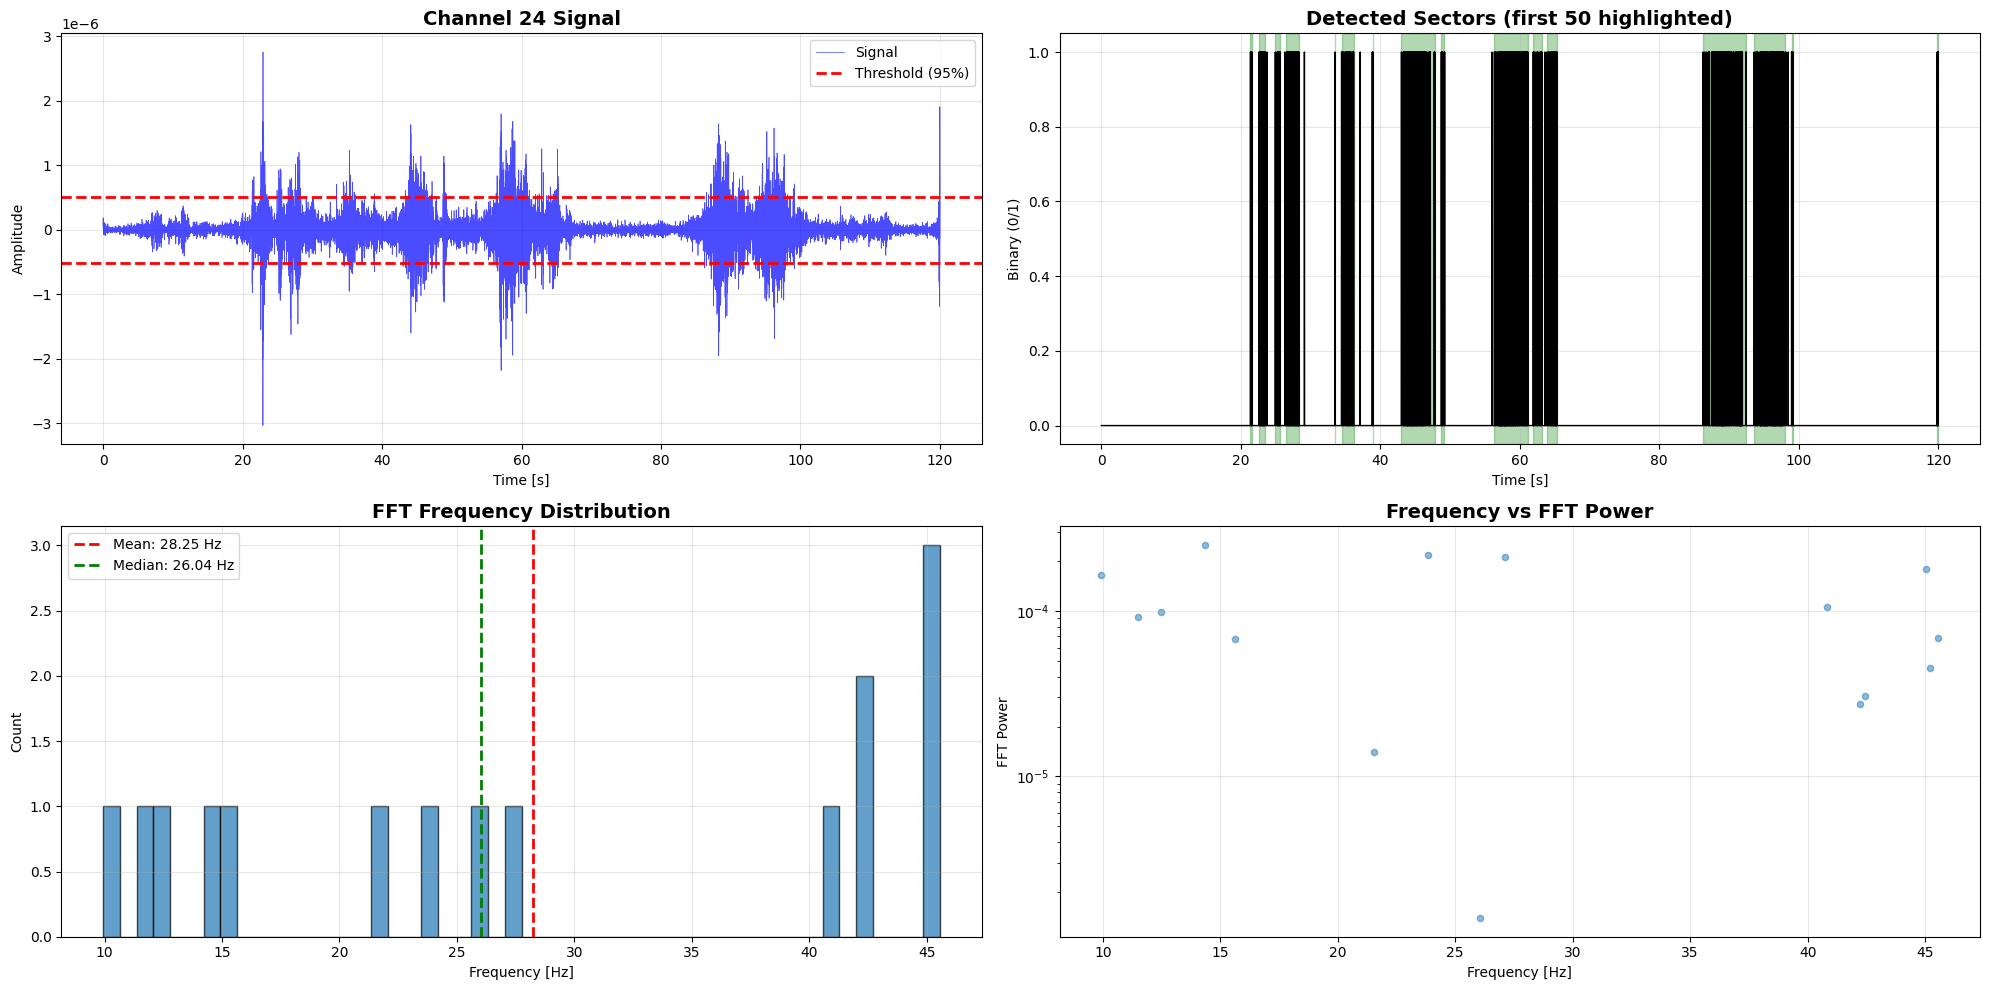



Detected frequencies (FFT): [42.4382716  40.83484574 45.55808656  9.93816254 11.49954002 26.04166667
 45.04504505 45.21276596 23.82943144 15.625      12.45847176 14.35113519
 27.12557809 21.55172414 42.22972973]
BANDSTOP FILTERING
Filtering all 52 channels
Removing 8 frequency bands:
  Removed 9.44-10.44 Hz (center: 9.94 Hz)
  Removed 11.96-12.96 Hz (center: 12.46 Hz)
  Removed 15.13-16.12 Hz (center: 15.63 Hz)
  Removed 11.96-12.96 Hz (center: 12.46 Hz)
  Removed 15.13-16.12 Hz (center: 15.63 Hz)
  Removed 21.05-22.05 Hz (center: 21.55 Hz)
  Removed 23.33-24.33 Hz (center: 23.83 Hz)
  Removed 21.05-22.05 Hz (center: 21.55 Hz)
  Removed 23.33-24.33 Hz (center: 23.83 Hz)
  Removed 25.54-26.54 Hz (center: 26.04 Hz)
  Removed 40.33-41.33 Hz (center: 40.83 Hz)
  Removed 25.54-26.54 Hz (center: 26.04 Hz)
  Removed 40.33-41.33 Hz (center: 40.83 Hz)
  Removed 44.55-45.55 Hz (center: 45.05 Hz)

HORIZONTAL SOBEL FILTER
Data shape: (75000, 52) (time x space)
Edge intensity multiplier: 1.0
Chan

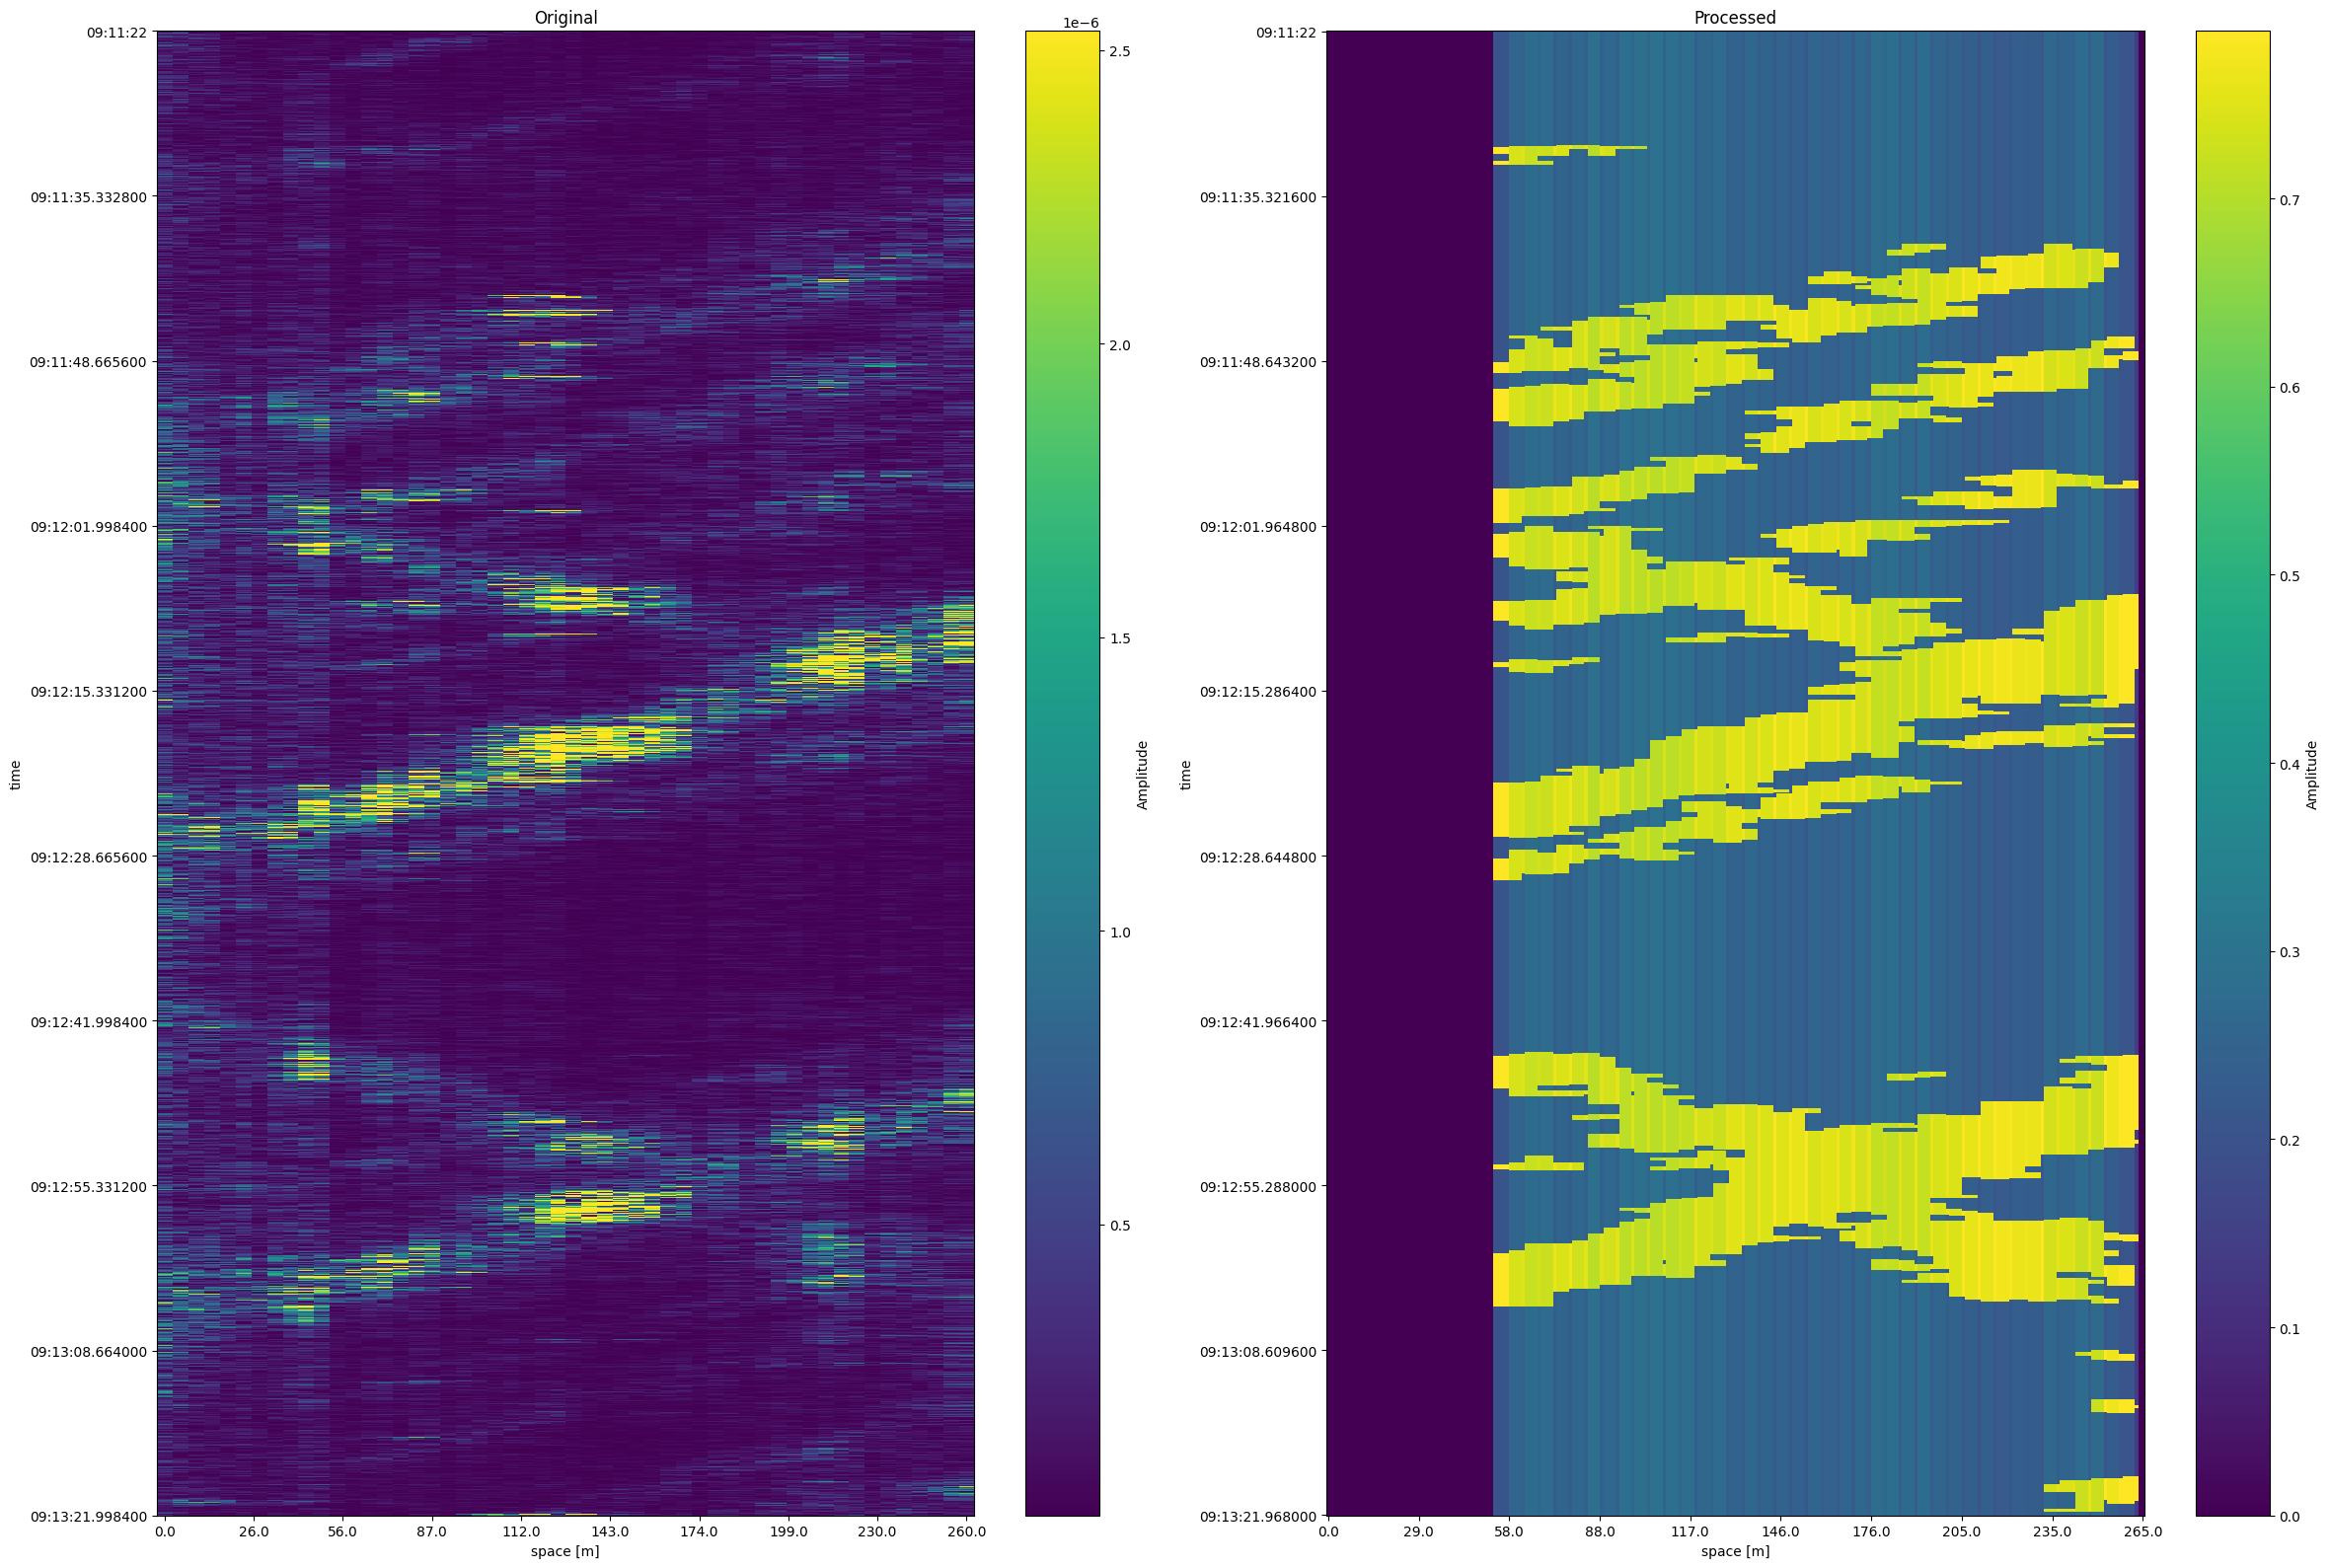

ASPECT RATIO CORRECTION
Original shape: (75000, 52) (time x space)
Original dt: 0.001600 s, dx: 5.1065 m
Scale time by: 0.0435
Scale space by: 5.0
Target shape: ~(3260 x 260)
Actual rescaled shape: (3261, 260)

New sampling:
  dt: 0.036800 s (was 0.001600 s, factor: 23.00x)
  dx: 1.0213 m (was 5.1065 m, factor: 0.20x)

Data statistics:
  Original - Mean: 2.653035e-07, Max: 4.431404e-05
  Rescaled - Mean: 2.382993e-07, Max: 3.255335e-05

LINE DETECTION - BFS WITH TRAJECTORY FOLLOWING
Data shape: (3261, 260) (time x channels)
Starting channel: 55
Starting points: 13
Threshold percentile: 60% (value: 0.000000)
Min component size: 10 pixels
Max branch angle: 45°

=== FIRST PASS: Collecting trajectories (overlaps allowed) ===

--- Processing starting point 1/13 at time=262 ---
  Component size: 1033 pixels

--- Processing starting point 2/13 at time=290 ---
  Component size: 1015 pixels

--- Processing starting point 3/13 at time=740 ---
  Component size: 19270 pixels

--- Processing starti

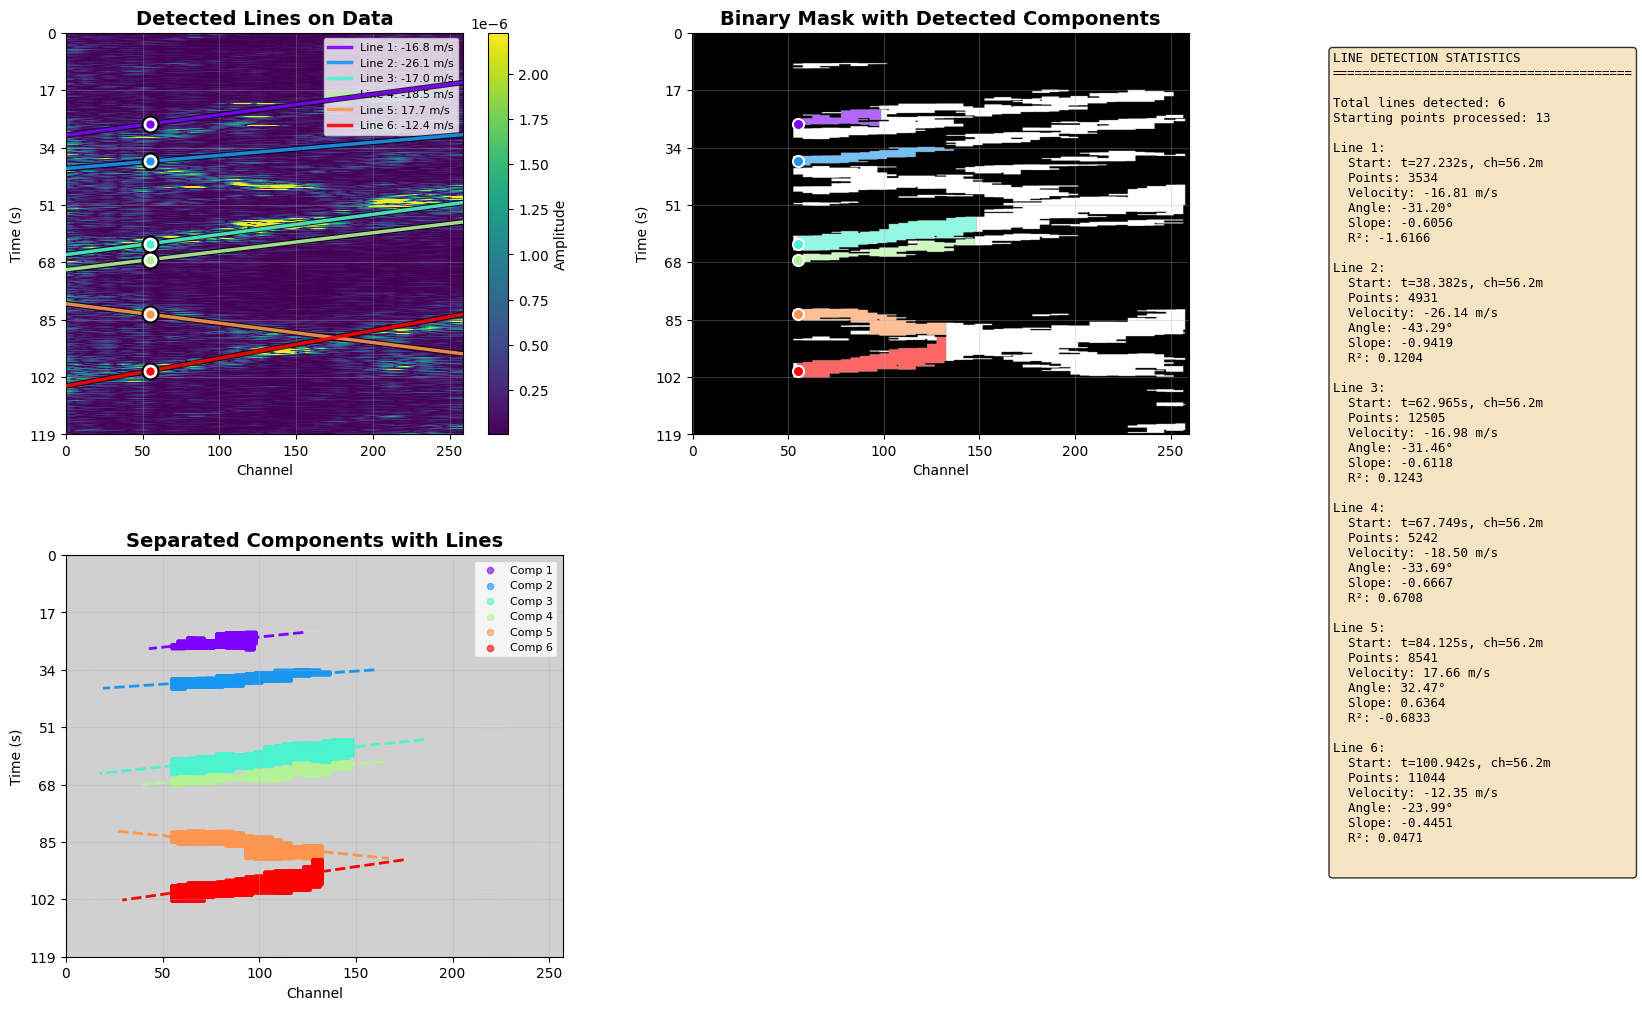

Line 1: velocity=-16.81 m/s, angle=-31.2°
Line 2: velocity=-26.14 m/s, angle=-43.3°
Line 3: velocity=-16.98 m/s, angle=-31.5°
Line 4: velocity=-18.50 m/s, angle=-33.7°
Line 5: velocity=17.66 m/s, angle=32.5°
Line 6: velocity=-12.35 m/s, angle=-24.0°


In [70]:
raw_data = get_range(*range2)
data = zero_columns(raw_data, 0, 12)
bandpass_data = bandpass_filter(data, lowcut=5, highcut=50, order=4)

# Find frequencies using FFT analysis
result_fft = find_channel_frequencies_fft(bandpass_data, 
                                          channel_index=24, 
                                          threshold_percentile=95, 
                                          merge_gap=450,
                                          min_freq=5,
                                          max_freq=50,
                                          top_n_peaks=1)
print("\nDetected frequencies (FFT):", result_fft['frequencies'])
merged_frequencies = merge_similar_values(list(result_fft['frequencies']), tolerance=2)
extracted_data = bandstop_filter_frequencies(bandpass_data, merged_frequencies, bandwidth=1.0)
sobel_data = horizontal_sobel_filter(extracted_data)
noise_removed = noise_removal_only(sobel_data, threshold_strong_percentile=85, threshold_weak_percentile=85)
resized_data = aspect_ratio_correction(noise_removed)
print(resized_data['data'].shape, resized_data['dt'], resized_data['dx'])
binary_data = binary_threshold_filter(resized_data, threshold_percentile=75)
morph_data = morphological_closing(binary_data, structure_size=(2, 3), iterations=2, threshold_percentile=0)
morph_data = morphological_opening(morph_data, structure_size=(2, 2), iterations=2, threshold_percentile=0)
morph_data = morphological_opening(morph_data, structure_size=(4, 2), iterations=2, threshold_percentile=0)
morph_data = morphological_closing(morph_data, structure_size=(5, 1), iterations=2, threshold_percentile=0)
morph_data = morphological_opening(morph_data, structure_size=(3, 3), iterations=2, threshold_percentile=0)
final_data = remove_small_objects(morph_data, min_size=250, threshold_percentile=0)
plot_comparison(raw_data, final_data)

resized_raw_data = aspect_ratio_correction(raw_data)

# Due to resizing and zeroing some channels, first channels might be empty
start_channel = 55

regions = detect_continuous_regions_channel(final_data, channel_index=start_channel)
starting_points = [r['midpoint'] for r in regions]

# Detect lines, display on original unprocessed data
result = line_detection_bfs(
    result=final_data,
    starting_points=starting_points,
    starting_channel=start_channel,
    threshold_percentile=60,
    display_data=resized_raw_data,  # Show lines on original data
    max_branch_angle=45
)

# Access results
for i, line in enumerate(result['lines']):
    print(f"Line {i+1}: velocity={line['velocity']:.2f} m/s, angle={line['angle']:.1f}°")
